<a href="https://colab.research.google.com/github/KripaMishra/LangChain/blob/main/SourceCodeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The following implementation is based on the following architecture**

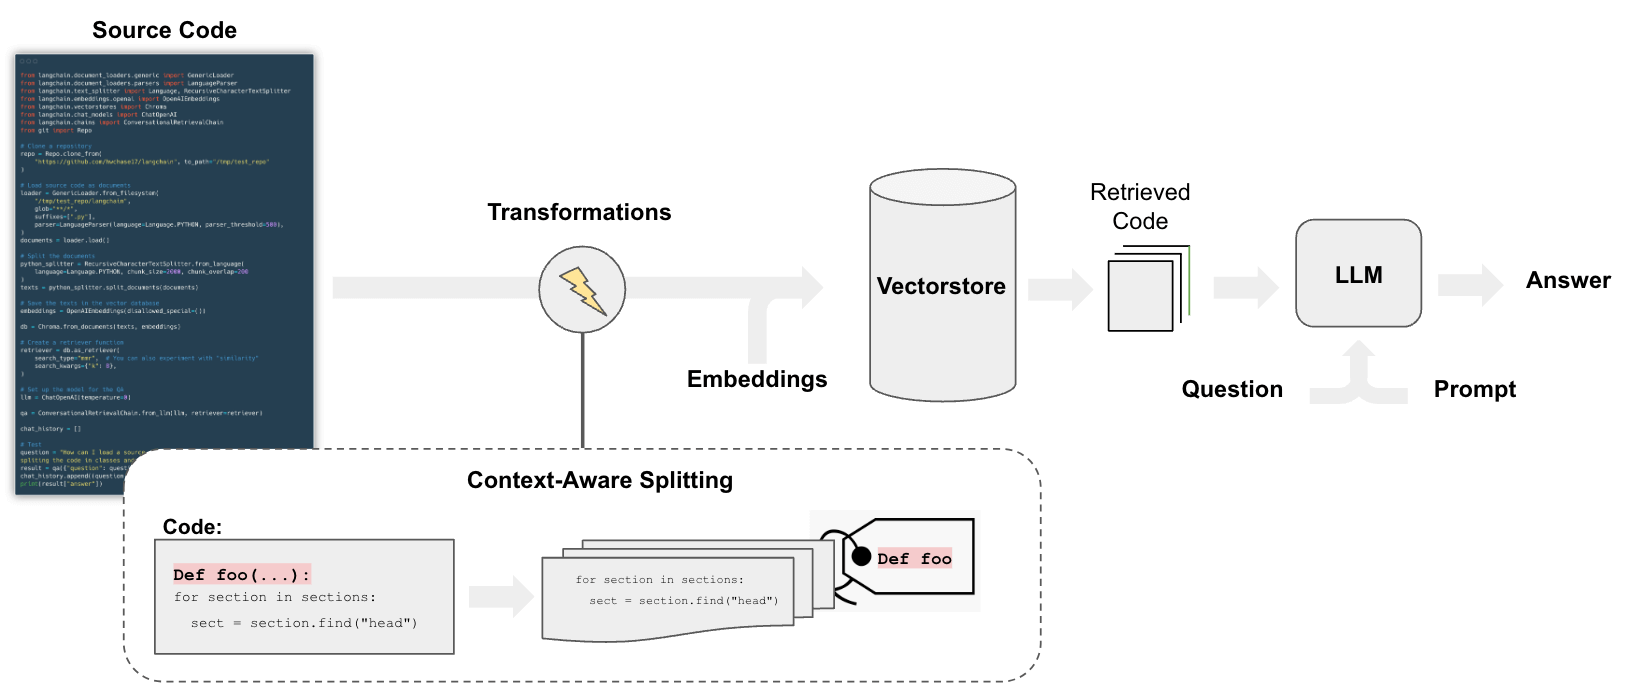

In [ ]:
!pip install langchain-openai
!pip install tiktoken
!pip install chromadb
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.4/278.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import userdata

In [ ]:
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import LanguageParser
from langchain_text_splitters import Language

In [ ]:
!pip install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
from git import Repo

Loader


In [ ]:
# sampel repo for cloning
repo_path = "/Users/jacoblee/Desktop/test_repo"
repo = Repo.clone_from("https://github.com/langchain-ai/langchain", to_path=repo_path)

In [ ]:
# Load
loader = GenericLoader.from_filesystem(
    repo_path + "/libs/core/langchain_core",
    glob="**/*",
    suffixes=[".py"],
    exclude=["**/non-utf8-encoding.py"],
    parser=LanguageParser(language=Language.PYTHON, parser_threshold=500),
)
documents = loader.load()
len(documents)

297

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

python_splitter= RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=5000, chunk_overlap=20
)

texts=python_splitter.split_documents(documents)

In [ ]:
len(texts)

475

# Embedding


In [ ]:
!pip install gpt4all

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 12.7 MB/s eta 0:00:00


In [ ]:
from langchain_community.embeddings import GPT4AllEmbeddings

In [ ]:
gpt4all_embd = GPT4AllEmbeddings()

Downloading: 100%|██████████| 45.9M/45.9M [00:00<00:00, 134MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 468MiB/s]


In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [ ]:
OPENAI_API_KEY=userdata.get("OPENAI_API_KEY")

In [ ]:
db=Chroma.from_documents(texts,gpt4all_embd)
retriever=db.as_retriever(
    search_type="mmr",
    search_kwargs={"k":1}
)

In [ ]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", openai_api_key=OPENAI_API_KEY)

In [ ]:
# First we need a prompt that we can pass into an LLM to generate this search query

prompt = ChatPromptTemplate.from_messages(
    [
        ("placeholder", "{chat_history}"),
        ("user", "{input}"),
        (
            "user",
            "Given the above conversation, generate a search query to look up to get information relevant to the conversation",
        ),
    ]
)

retriever_chain = create_history_aware_retriever(llm, retriever, prompt)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the user's questions based on the below context:\n\n{context}",
        ),
        ("placeholder", "{chat_history}"),
        ("user", "{input}"),
    ]
)
document_chain = create_stuff_documents_chain(llm, prompt)

qa = create_retrieval_chain(retriever_chain, document_chain)

In [ ]:
question = "What is a RunnableBinding?"
result = qa.invoke({"input": question})
result["answer"]

'A `RunnableBinding` is a base class that other classes can inherit from in Langchain Core. It provides basic functionality for runnables in the Langchain framework.'

In [ ]:
questions = [
    "What classes are derived from the Runnable class?",
    "What one improvement do you propose in code in relation to the class hierarchy for the Runnable class?",
]

for question in questions:
    result = qa.invoke({"input": question})
    print(f"-> **Question**: {question} \n")
    print(f"**Answer**: {result['answer']} \n")

-> **Question**: What classes are derived from the Runnable class? 

**Answer**: The classes derived from the `Runnable` class are:
- `RunnableSerializable`
- `RunnableBinding`
- `RunnableBranch`
- `RunnableConfig`
- `RunnableGenerator`
- `RunnableLambda`
- `RunnableMap`
- `RunnableParallel`
- `RunnablePassthrough`
- `RunnableAssign`
- `RunnablePick`
- `RunnableSequence`
- `RunnableWithFallbacks` 

-> **Question**: What one improvement do you propose in code in relation to the class hierarchy for the Runnable class? 

**Answer**: One improvement that could be proposed in the code in relation to the class hierarchy for the `Runnable` class is to introduce a clearer separation of concerns by potentially creating an abstract base class that defines the core functionality shared by all runnables. This abstract base class could serve as the parent class for both the `Runnable` class and the `RunnableBinding` class.

By having a clear separation between the core functionality of runnables pr